In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from matplotlib import pyplot as plt

In [2]:

class Perceptron:
    def __init__(self, num_features, hidden_layers, num_classes, activations, loss_function):
        self.num_features = num_features
        self.activations = activations
        self.loss_function = loss_function
        self.hidden_layers = hidden_layers
        self.num_classes = num_classes
        self.num_layers = len(hidden_layers) + 1
        self.W = []
        self.B = []
        self.Z = []
        self.A = []
        self.history = None
        self._init_params()

    def _init_params(self):
        self.W.append(np.random.rand(self.hidden_layers[0], self.num_features))  # input - hidden
        first_hidden = 0
        last_hidden = self.num_layers - 2
        for i in range(first_hidden, last_hidden):
            self.W.append(np.random.rand(self.hidden_layers[i + 1], self.hidden_layers[i]))
        # self.W.append(np.random.rand(self.hidden_layers[1], self.hidden_layers[0]))
        # self.W.append(np.random.rand(self.hidden_layers[2], self.hidden_layers[1]))
        self.W.append(np.random.rand(self.num_classes, self.hidden_layers[last_hidden]))  # hidden - output

        for i in range(first_hidden, last_hidden + 1):
            self.B.append(np.random.rand(self.hidden_layers[i]))
        # self.B.append(np.random.rand(self.hidden_layers[0])) # first hidden
        # self.B.append(np.random.rand(self.hidden_layers[1]))
        # self.B.append(np.random.rand(self.hidden_layers[2])) # last hidden
        self.B.append(np.random.rand(self.num_classes))  # output

        for _ in range(self.num_layers):
            # create list placeholders for Z and A
            self.Z.append(None)
        for _ in range(self.num_layers - 1):
            self.A.append(None)
        self.history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    def predict_sample(self, X):
        Z0 = np.dot(self.W[0], X) + self.B[0]
        self.Z[0] = Z0
        A0 = self.activations[0](Z0)
        self.A[0] = A0

        # Z1 = np.dot(self.W[1], A0) + self.B[1]
        # self.Z[1] = Z1
        # A1 = self.activations[1](Z1)
        # self.A[1] = A1
        #
        # Z2 = np.dot(self.W[2], A1) + self.B[2]
        # self.Z[2] = Z2
        # A2 = self.activations[2](Z2)
        # self.A[2] = A2

        for i in range(1, self.num_layers - 1):
            Z = np.dot(self.W[i], self.A[i - 1]) + self.B[i]
            self.Z[i] = Z
            A = self.activations[i](Z)
            self.A[i] = A

        Z_last = np.dot(self.W[-1], self.A[-1]) + self.B[-1]
        self.Z[-1] = Z_last
        A_last = self.activations[-1](Z_last)
        return A_last

    def predict_batch(self, X):
        predictions = []
        for element in X:
            predictions.append(self.predict_sample(element))
        return np.array(predictions)

    def train(self, x_train, y_train, x_test, y_test, learning_rate=0.1, epochs=100):
        for epoch in range(epochs):
            total_losses = 0
            for i in range(len(x_train)):
                x_i = np.array(x_train[i])
                Yh = self.predict_sample(x_train[i])
                loss = self.loss_function(y_train[i], Yh)
                total_losses += loss

                last_hidden = self.num_layers - 2
                first_hidden = 1

                # output layer
                dloss_Yh = self.loss_function(y_train[i], Yh, der=True)
                dloss_A3 = dloss_Yh

                dout = self.activations[-1](self.Z[-1], der=True)

                if(dout.size == 9):
                    dloss_Z = np.dot(dloss_A3, dout)
                else:
                    dloss_Z = dloss_A3 * dout   
                    
                dloss_A = np.dot(self.W[-1].T, dloss_Z)
                dloss_W3 = np.kron(dloss_Z, self.A[-1]).reshape(self.num_classes, self.hidden_layers[last_hidden])
                dloss_B3 = dloss_Z

                hd_dloss_Z = []
                hd_dloss_A = []
                hd_dloss_W = []
                hd_dloss_B = []

                for i_hd_lay in reversed(range(first_hidden, last_hidden + 1)):
                    dloss_Z = dloss_A * self.activations[i_hd_lay](self.Z[i_hd_lay], der=True)
                    hd_dloss_Z.insert(0, dloss_Z)
                    dloss_A = np.dot(self.W[i_hd_lay].T, dloss_Z)
                    hd_dloss_A.insert(0, dloss_A)
                    dloss_W1 = np.kron(dloss_Z, self.A[i_hd_lay - 1]).reshape(self.hidden_layers[i_hd_lay],
                                                                              self.hidden_layers[i_hd_lay - 1])
                    hd_dloss_W.insert(0, dloss_W1)
                    dloss_B1 = dloss_Z
                    hd_dloss_B.insert(0, dloss_B1)

                # input layer
                dloss_Z0 = dloss_A * self.activations[0](self.Z[0], der=True)
                dloss_W0 = np.kron(dloss_Z0, x_i).reshape(self.hidden_layers[0], self.num_features)
                dloss_B0 = dloss_Z0

                # output layer
                self.W[-1] -= learning_rate * dloss_W3
                self.B[-1] -= learning_rate * dloss_B3

                # hidden layers
                for i in range(first_hidden, last_hidden):
                    self.W[i + 1] -= learning_rate * hd_dloss_W[i]
                    self.B[i + 1] -= learning_rate * hd_dloss_B[i]
                # input layer
                self.W[0] -= learning_rate * dloss_W0
                self.B[0] -= learning_rate * dloss_B0
            # evaluate the model
            self.history["train_acc"].append(self.score(x_train, y_train))
            self.history["val_acc"].append(self.score(x_test, y_test))
            self.history["train_loss"].append(
                self.loss_function(y_train, self.predict_batch(x_train)) / len(y_train))
            self.history["val_loss"].append(
                self.loss_function(y_test, self.predict_batch(x_test)) / len(y_test))
            if epoch % 50 == 0:
                print(
                    f"epoch: {epoch}; train loss: {self.history['train_loss'][-1]}; val loss: {self.history['val_loss'][-1]}")
                print(f"train acc: {self.history['train_acc'][-1]}; val acc: {self.history['val_acc'][-1]}\n")

    def score(self, X, y):
        predictions = self.predict_batch(X)
        return np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)


def ccategorical_crossentropy(y_true, y_pred, der=False):
    if der:
        return (y_pred - y_true) / y_true.shape
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -np.sum(y_true * np.log(y_pred))


def sigmoid(x, der=False):
    if der:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))


def softmax(x, der=False):
    if der:
        s = softmax(x)
        return np.diag(s) - np.outer(s, s)
    return (np.exp(x) / np.exp(x).sum())


def relu(x, der=False):
    if der:
        f = np.heaviside(x, 1)
    else:
        f = np.maximum(x, 0)
    return f

In [3]:
X, y = datasets.load_wine(return_X_y=True)
y_cat = []
converter = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
}
for label in y:
    y_cat.append(np.array(converter[label]))
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2)

## 2LP

In [4]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 1.4733698377694822; val loss: 1.4736232596177643
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 50; train loss: 1.0881013513227962; val loss: 1.0793635221236064
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 100; train loss: 1.0826680104193398; val loss: 1.074101719822932
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 150; train loss: 1.0767310018129912; val loss: 1.0684241316193626
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 200; train loss: 1.0695354309026317; val loss: 1.0616406623451884
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 250; train loss: 1.0598021868348328; val loss: 1.052607583128226
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 300; train loss: 1.0449061870922378; val loss: 1.0390221423075077
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 350; train loss: 1.0186351246380012; val loss: 1.01553245965

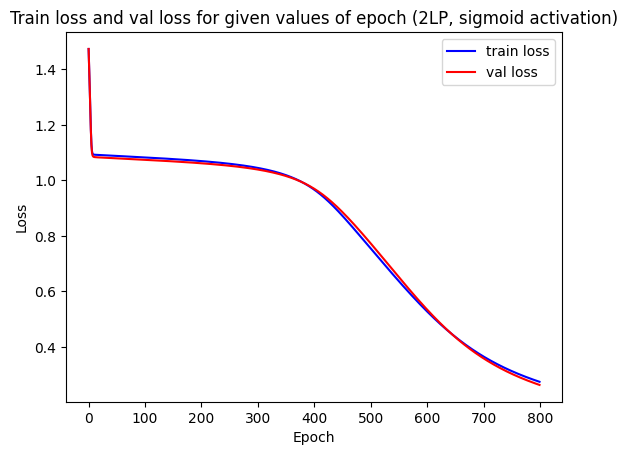

In [5]:

plt.title("Train loss and val loss for given values of epoch (2LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

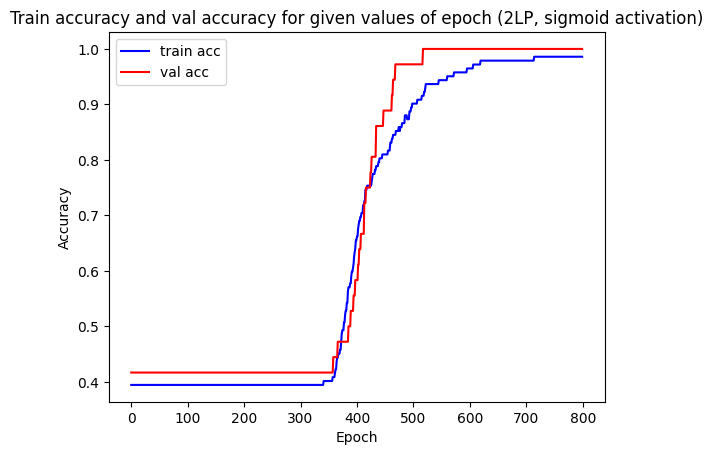

In [6]:
plt.title("Train accuracy and val accuracy for given values of epoch (2LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

## 3LP


In [7]:
hidden_layers = [8, 8]
activations = [sigmoid] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 1.136887318082483; val loss: 1.1464622693473412
train acc: 0.2746478873239437; val acc: 0.25

epoch: 50; train loss: 1.0882255112558537; val loss: 1.0795807891739382
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 100; train loss: 1.088219671013979; val loss: 1.0795742346632522
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 150; train loss: 1.0882138561070835; val loss: 1.0795677076871861
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 200; train loss: 1.0882080660462605; val loss: 1.0795612075809684
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 250; train loss: 1.0882023003448231; val loss: 1.0795547337945346
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 300; train loss: 1.0881965585221778; val loss: 1.0795482857846728
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 350; train loss: 1.0881908401036733; val loss: 1.0795418630148528
train acc

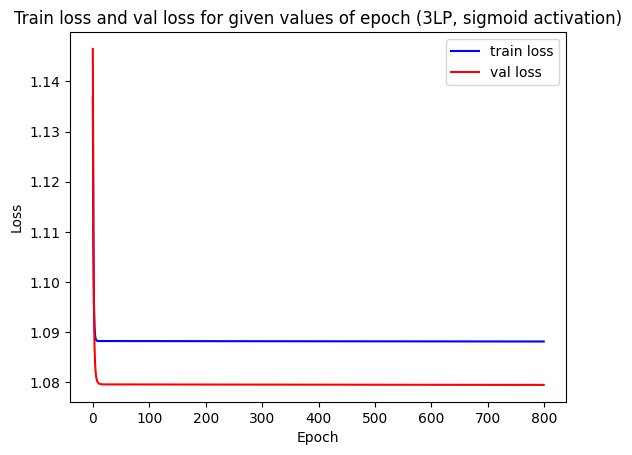

In [8]:
plt.title("Train loss and val loss for given values of epoch (3LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

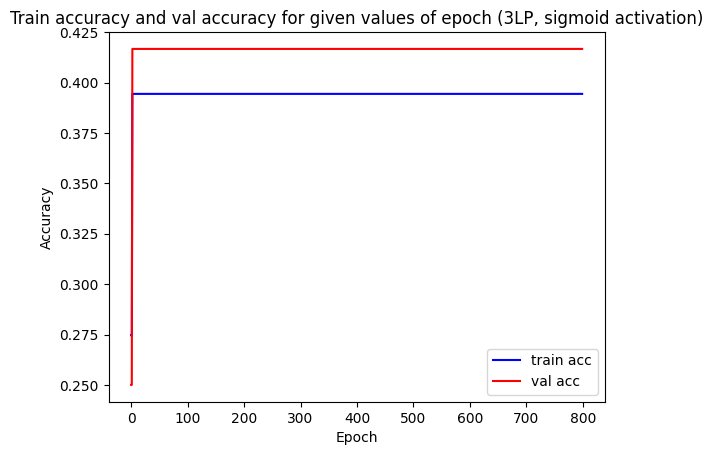

In [9]:
plt.title("Train accuracy and val accuracy for given values of epoch (3LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

vanishing gradient problem

In [10]:
hidden_layers = [8, 8]
activations = [relu] * len(hidden_layers) + [softmax]
perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)

perceptron.train(X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=800)

epoch: 0; train loss: 10.300463749137991; val loss: 10.554010482678734
train acc: 0.2746478873239437; val acc: 0.25

epoch: 50; train loss: 6.918915411335094; val loss: 7.068063545837367
train acc: 0.6197183098591549; val acc: 0.5833333333333334

epoch: 100; train loss: 6.688287195204918; val loss: 6.856336330724134
train acc: 0.6549295774647887; val acc: 0.5833333333333334

epoch: 150; train loss: 6.5841575267244075; val loss: 6.742829426697203
train acc: 0.6549295774647887; val acc: 0.6111111111111112

epoch: 200; train loss: 6.502045973642008; val loss: 6.643849900995819
train acc: 0.6619718309859155; val acc: 0.6111111111111112

epoch: 250; train loss: 6.421695592844896; val loss: 6.551984493271671
train acc: 0.6619718309859155; val acc: 0.6111111111111112

epoch: 300; train loss: 6.338659944997217; val loss: 6.460227050030401
train acc: 0.6619718309859155; val acc: 0.6111111111111112

epoch: 350; train loss: 6.252806931261781; val loss: 6.37330075629476
train acc: 0.66197183098591

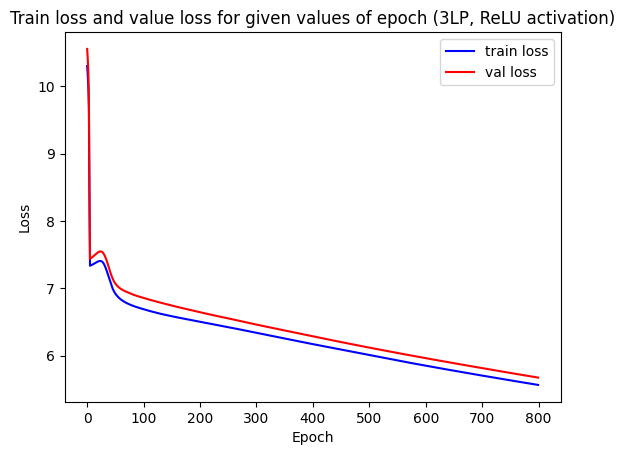

In [11]:
plt.title("Train loss and value loss for given values of epoch (3LP, ReLU activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()

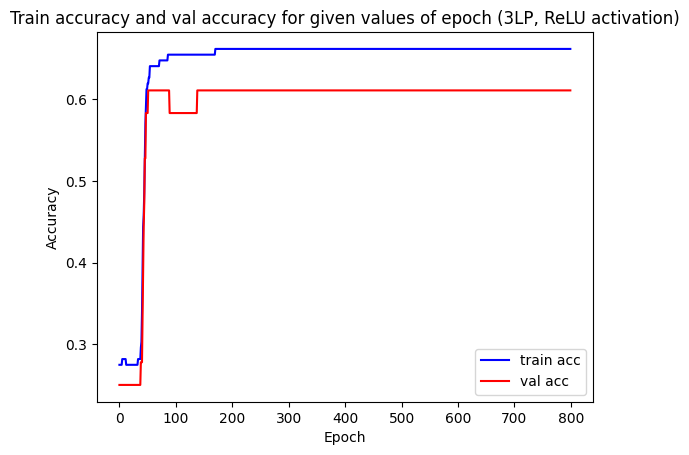

In [12]:
plt.title("Train accuracy and val accuracy for given values of epoch (3LP, ReLU activation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(perceptron.history["train_acc"], label="train acc", color="blue")
plt.plot(perceptron.history["val_acc"], label="val acc", color="red")
plt.legend()

so relu was a solution to the vanishing gradient problem


*In deep neural networks, the vanishing gradient problem is a phenomenon where the gradients of the parameters with respect to the loss function become very small, leading to slow or stalled training. It is particularly common in networks with many layers, such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs).

The problem arises because the gradients are multiplied by the weights during backpropagation, and if the weights are small, then the gradients will also be small. This can make it difficult for the network to learn, since the weight updates will be very small and may not be able to overcome the initial randomness of the weights.

There are several ways to address the vanishing gradient problem, including using better weight initialization techniques, using non-linear activation functions such as ReLU, and using techniques such as skip connections and batch normalization.

It is possible that using more than one hidden layer in your perceptron is causing the vanishing gradient problem, leading to poor performance. The vanishing gradient problem is more likely to occur in deeper networks, where there are many layers, so using a single hidden layer may be sufficient for your task.

There could be other factors contributing to the difference in performance as well. For example, the number of units in the hidden layer and the choice of activation function could also impact the network's ability to learn. It is worth experimenting with different architectures and hyperparameters to see what works best for your particular task and dataset.

In general, it is important to be mindful of the vanishing gradient problem when training deep neural networks, and to consider using techniques such as weight initialization, non-linear activation functions, and skip connections to mitigate the issue.*



# Learning rate


epoch: 0; train loss: 1.7614517512682517; val loss: 1.7049421473314366
train acc: 0.33098591549295775; val acc: 0.3333333333333333

epoch: 50; train loss: 1.26817365300651; val loss: 1.2189879200792553
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 100; train loss: 1.1033811793875843; val loss: 1.0862935542276881
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 150; train loss: 1.094516115220825; val loss: 1.0846813691916464
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 200; train loss: 1.0941058583163008; val loss: 1.0845694623160134
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 250; train loss: 1.0937183283034355; val loss: 1.0841626791768946
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 300; train loss: 1.0933342538745654; val loss: 1.0837471250584878
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 350; train loss: 1.092953369670733; val loss: 1.0833343664044

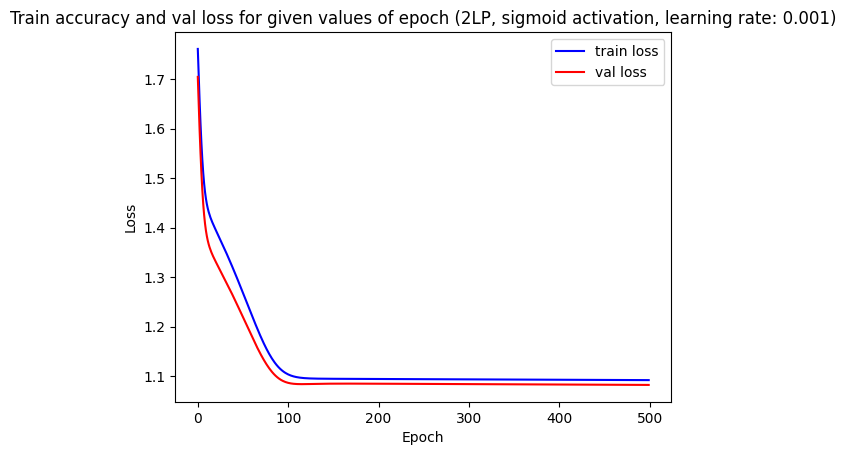

epoch: 0; train loss: 1.407412851083233; val loss: 1.43219150533536
train acc: 0.33098591549295775; val acc: 0.3333333333333333

epoch: 50; train loss: 1.08800421901528; val loss: 1.076942203222269
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 100; train loss: 1.0837547283904059; val loss: 1.0724854707750542
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 150; train loss: 1.0789997814168168; val loss: 1.067439171084076
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 200; train loss: 1.0730848720560093; val loss: 1.0611147000546728
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 250; train loss: 1.0647253196800894; val loss: 1.05218205692185
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 300; train loss: 1.0508752198781761; val loss: 1.03759740900286
train acc: 0.5211267605633803; val acc: 0.5833333333333334

epoch: 350; train loss: 1.0239145133094476; val loss: 1.0102070339508809
trai

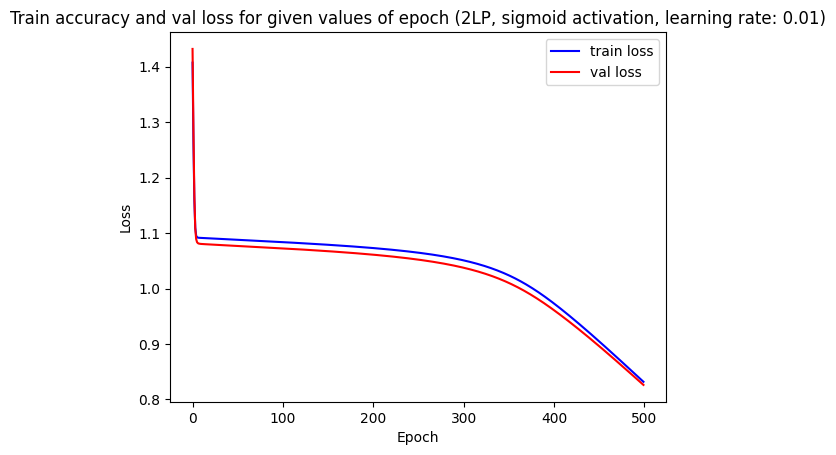

epoch: 0; train loss: 1.1002829047644644; val loss: 1.1000840100415863
train acc: 0.176056338028169; val acc: 0.1111111111111111

epoch: 50; train loss: 0.527852449922781; val loss: 0.5033953047079206
train acc: 0.9647887323943662; val acc: 0.9722222222222222

epoch: 100; train loss: 0.16545266837236208; val loss: 0.15142524363222543
train acc: 0.9929577464788732; val acc: 1.0

epoch: 150; train loss: 0.1038915851128179; val loss: 0.10187115981671552
train acc: 0.9929577464788732; val acc: 1.0

epoch: 200; train loss: 0.07717990543359361; val loss: 0.08157436143912562
train acc: 1.0; val acc: 1.0

epoch: 250; train loss: 0.062141848676949066; val loss: 0.07020770837621798
train acc: 1.0; val acc: 1.0

epoch: 300; train loss: 0.0524134351430466; val loss: 0.06282200506712352
train acc: 1.0; val acc: 1.0

epoch: 350; train loss: 0.04555424735387945; val loss: 0.05760109320323825
train acc: 1.0; val acc: 1.0

epoch: 400; train loss: 0.04043203128090021; val loss: 0.05370409573610566
train

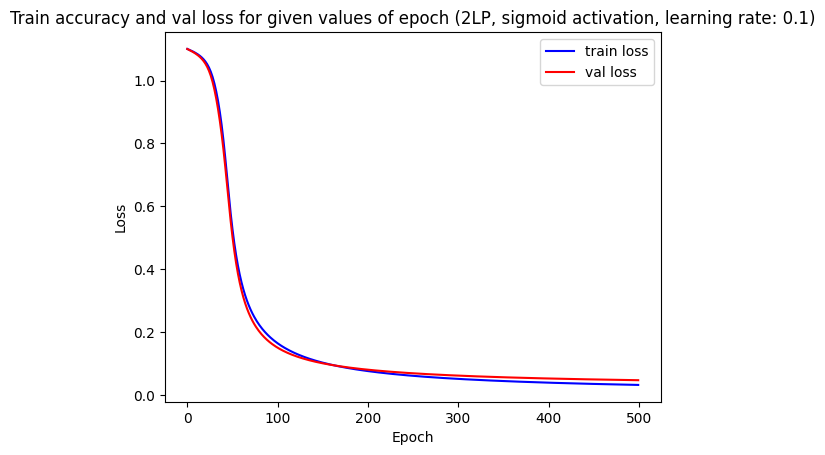

epoch: 0; train loss: 1.1723793111424337; val loss: 1.1860654773187236
train acc: 0.2746478873239437; val acc: 0.25

epoch: 50; train loss: 0.06246455609748839; val loss: 0.06211231493036053
train acc: 1.0; val acc: 1.0

epoch: 100; train loss: 0.02992836975168608; val loss: 0.03747617271666148
train acc: 1.0; val acc: 1.0

epoch: 150; train loss: 0.02072291728086461; val loss: 0.030830921327581792
train acc: 1.0; val acc: 1.0

epoch: 200; train loss: 0.016317865578194184; val loss: 0.027921896180907554
train acc: 1.0; val acc: 1.0

epoch: 250; train loss: 0.013687821791038826; val loss: 0.026252464278942716
train acc: 1.0; val acc: 1.0

epoch: 300; train loss: 0.011917335912736854; val loss: 0.025123651806153398
train acc: 1.0; val acc: 1.0

epoch: 350; train loss: 0.010631942176583507; val loss: 0.02428312581658559
train acc: 1.0; val acc: 1.0

epoch: 400; train loss: 0.00964945128749275; val loss: 0.02361925271237823
train acc: 1.0; val acc: 1.0

epoch: 450; train loss: 0.0088700107

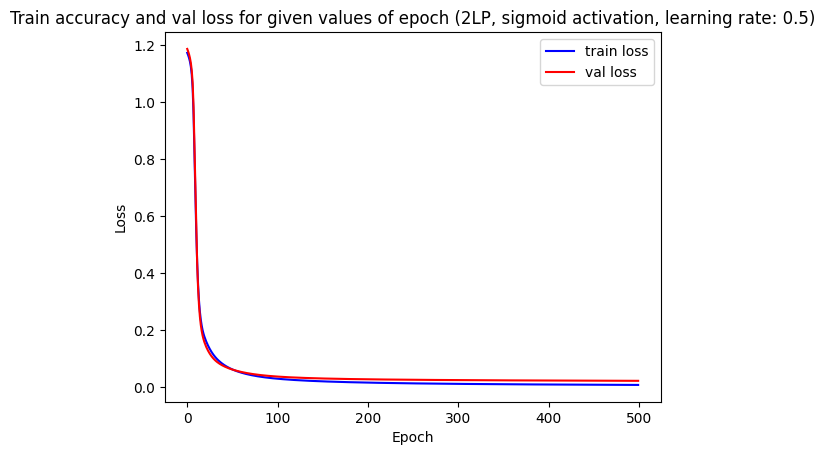

epoch: 0; train loss: 1.1686251070306692; val loss: 1.183374405545145
train acc: 0.2746478873239437; val acc: 0.25

epoch: 50; train loss: 0.0313337868601402; val loss: 0.04748218012279656
train acc: 1.0; val acc: 1.0

epoch: 100; train loss: 0.01427670262490606; val loss: 0.03381956447289539
train acc: 1.0; val acc: 1.0

epoch: 150; train loss: 0.010318566236303913; val loss: 0.03119746148889741
train acc: 1.0; val acc: 1.0

epoch: 200; train loss: 0.008389390182857644; val loss: 0.030351025372108962
train acc: 1.0; val acc: 1.0

epoch: 250; train loss: 0.007197691971229504; val loss: 0.02994757676312581
train acc: 1.0; val acc: 1.0

epoch: 300; train loss: 0.006371367957976928; val loss: 0.029709267747536214
train acc: 1.0; val acc: 1.0

epoch: 350; train loss: 0.0057571860245922; val loss: 0.029551825310879836
train acc: 1.0; val acc: 1.0

epoch: 400; train loss: 0.005278825604244519; val loss: 0.029441020379274947
train acc: 1.0; val acc: 1.0

epoch: 450; train loss: 0.004893438473

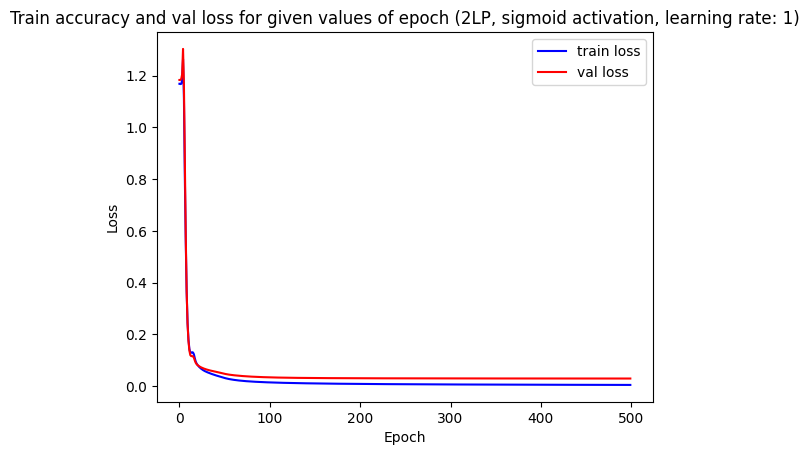

In [13]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [softmax]

i = 1
for x in [.001, .01, .1, .5, 1]:
    perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
    perceptron.train(X_train, y_train, X_test, y_test, learning_rate=x, epochs=500)
    plt.figure(i)
    plt.title(f"Train accuracy and val loss for given values of epoch (2LP, sigmoid activation, learning rate: {x})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
    plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
    plt.legend()
    plt.show()
    i += 1

epoch: 0; train loss: 1.1099012570023854; val loss: 1.112946905866255
train acc: 0.23943661971830985; val acc: 0.2222222222222222

epoch: 50; train loss: 0.9363745370430779; val loss: 0.929219991357257
train acc: 0.7323943661971831; val acc: 0.6944444444444444

epoch: 100; train loss: 0.2115128880773052; val loss: 0.19624389088641409
train acc: 0.9788732394366197; val acc: 1.0

epoch: 150; train loss: 0.11909622800073044; val loss: 0.11329733543631801
train acc: 0.9929577464788732; val acc: 1.0

epoch: 200; train loss: 0.08454136875081303; val loss: 0.08654192069882136
train acc: 1.0; val acc: 1.0



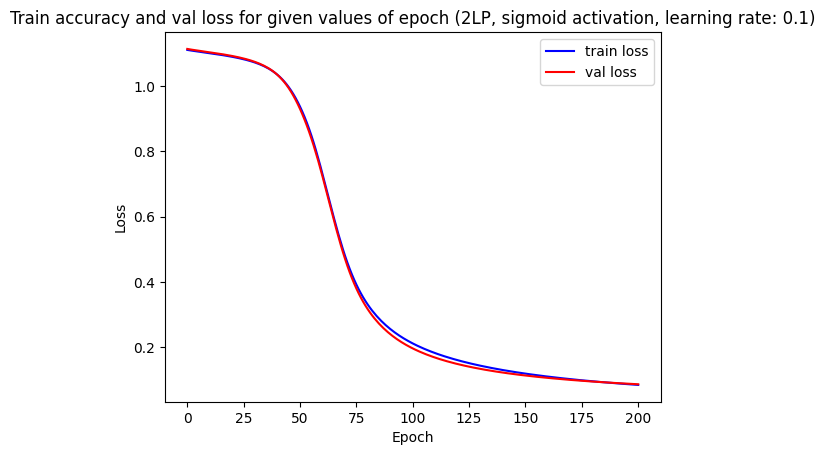

epoch: 0; train loss: 1.1690071960825092; val loss: 1.1840672065332356
train acc: 0.2746478873239437; val acc: 0.25

epoch: 50; train loss: 0.06726644519060233; val loss: 0.0678587604372562
train acc: 0.9929577464788732; val acc: 1.0

epoch: 100; train loss: 0.032399617207172576; val loss: 0.04683138256783205
train acc: 1.0; val acc: 1.0

epoch: 150; train loss: 0.022041288090875133; val loss: 0.040840194746200736
train acc: 1.0; val acc: 1.0

epoch: 200; train loss: 0.01715954615217722; val loss: 0.03897687096005048
train acc: 1.0; val acc: 1.0



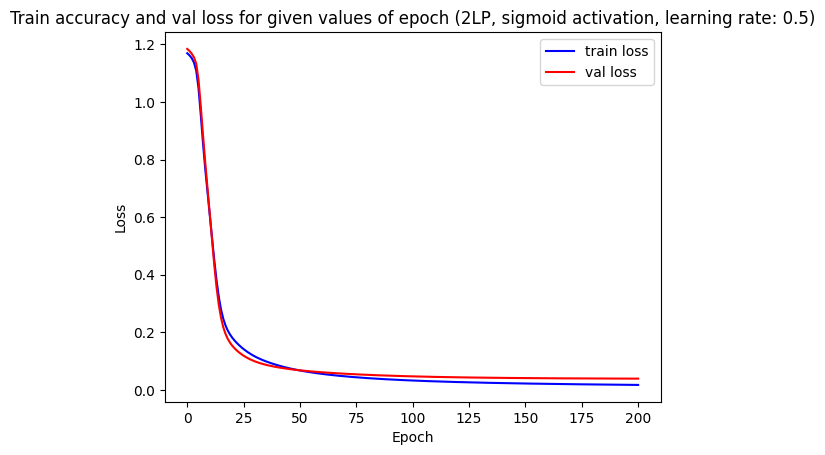

In [17]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [softmax]

i = 1
for x in [.1, .5]:
    perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
    perceptron.train(X_train, y_train, X_test, y_test, learning_rate=x, epochs=201)
    plt.figure(i)
    plt.title(f"Train accuracy and val loss for given values of epoch (2LP, sigmoid activation, learning rate: {x})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
    plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
    plt.legend()
    plt.show()
    i += 1

- In case of the highest learning rate (1) we can observe the phenomenon of overfitting. The higher epoch, the higher val los is, while train loss remains the same.
- to small learning rate (0.001) is not enough to learn the data
- optimal learning rate is 0.1 or 0.5, 0.5 converges faster, but 0.1 is more stable

# Activation functions comparison (classification)

epoch: 0; train loss: 0.0006875792978906747; val loss: 0.0007064667404857643
train acc: 0.2746478873239437; val acc: 0.25

epoch: 50; train loss: 0.0008749417106763732; val loss: 0.0008999712815862688
train acc: 0.2746478873239437; val acc: 0.25

epoch: 100; train loss: 0.0012117663365557982; val loss: 0.001248455358446307
train acc: 0.2746478873239437; val acc: 0.25

epoch: 150; train loss: 0.0020147997272362966; val loss: 0.0020817370520760784
train acc: 0.2746478873239437; val acc: 0.25

epoch: 200; train loss: 0.007479657302036605; val loss: 0.007788706040967476
train acc: 0.2746478873239437; val acc: 0.25

epoch: 250; train loss: 0.3715946377963882; val loss: 0.3907851422669511
train acc: 0.2746478873239437; val acc: 0.25

epoch: 300; train loss: 0.7352718061328419; val loss: 0.7575199875299437
train acc: 0.2746478873239437; val acc: 0.25

epoch: 350; train loss: 0.7329355646345118; val loss: 0.7549790527579426
train acc: 0.2746478873239437; val acc: 0.25

epoch: 400; train loss: 

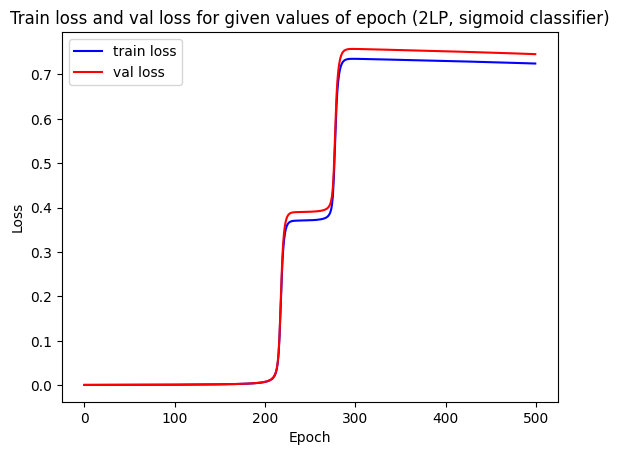

epoch: 0; train loss: 1.3737027732406082; val loss: 1.396745456427681
train acc: 0.2746478873239437; val acc: 0.25

epoch: 50; train loss: 1.0758964098943602; val loss: 1.0667235880715171
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 100; train loss: 1.0689040330233703; val loss: 1.0595266298389185
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 150; train loss: 1.0598518063074207; val loss: 1.050199936216473
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 200; train loss: 1.0468917749724826; val loss: 1.0368308658044068
train acc: 0.4014084507042254; val acc: 0.4166666666666667

epoch: 250; train loss: 1.0263055067213016; val loss: 1.0156009866532822
train acc: 0.5; val acc: 0.6111111111111112

epoch: 300; train loss: 0.9900778670382011; val loss: 0.9784774070865756
train acc: 0.5915492957746479; val acc: 0.6944444444444444

epoch: 350; train loss: 0.9219393023392763; val loss: 0.9101331787539321
train acc: 0.71830985915492

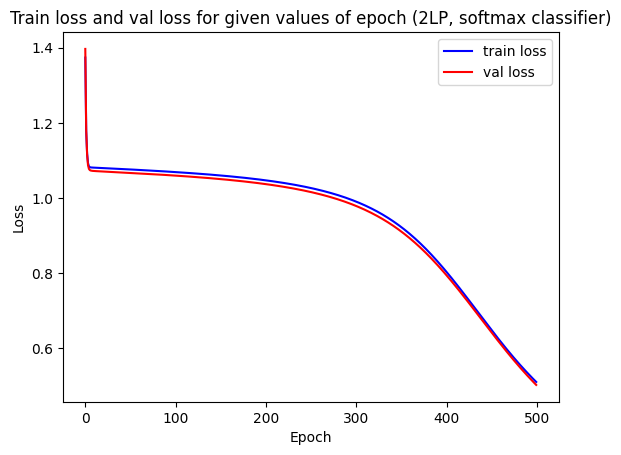

In [14]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [sigmoid]

perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
perceptron.train(X_train, y_train, X_test, y_test, learning_rate=.01, epochs=500)

plt.title(f"Train loss and val loss for given values of epoch (2LP, sigmoid classifier)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()
plt.show()

activations = [sigmoid] * len(hidden_layers) + [softmax]

perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
perceptron.train(X_train, y_train, X_test, y_test, learning_rate=.01, epochs=500)

plt.title(f"Train loss and val loss for given values of epoch (2LP, softmax classifier)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()
plt.show()

It is observable, that Softmax is the best choice for classification. Sigmoid breaks the network and is unable to perform effectively. 

# Amounts and widths of layers comparison


epoch: 0; train loss: 1.2885287563759207; val loss: 1.3128096524205213
train acc: 0.33098591549295775; val acc: 0.3333333333333333

epoch: 50; train loss: 1.0902417971786538; val loss: 1.0809756427262818
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 100; train loss: 1.0846941598134716; val loss: 1.0754087003771622
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 150; train loss: 1.0790947156283122; val loss: 1.0698164283370768
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 200; train loss: 1.0729662662910786; val loss: 1.0637456283894349
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 250; train loss: 1.0656831097549764; val loss: 1.0566117843357758
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 300; train loss: 1.0562360667764905; val loss: 1.0474891698329503
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 350; train loss: 1.0427103190772504; val loss: 1.034650070

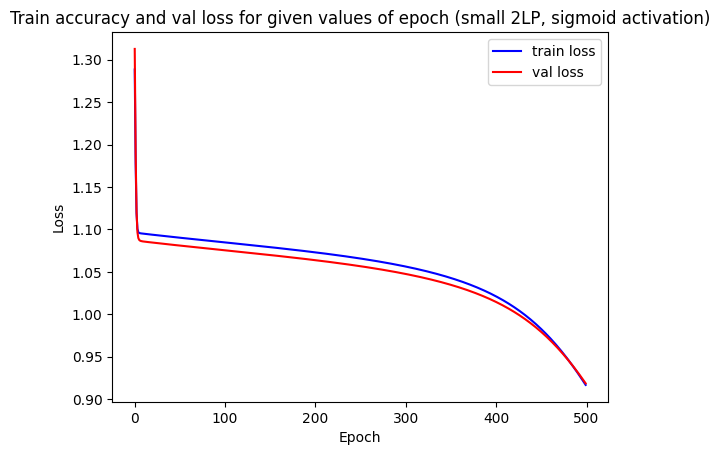

epoch: 0; train loss: 1.1060370483638882; val loss: 1.0885606454985082
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 50; train loss: 1.0878386969747427; val loss: 1.0792886752164648
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 100; train loss: 1.0878386969738512; val loss: 1.079288675206791
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 150; train loss: 1.0878386969729594; val loss: 1.0792886751971167
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 200; train loss: 1.0878386969720677; val loss: 1.079288675187441
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 250; train loss: 1.087838696971176; val loss: 1.079288675177765
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 300; train loss: 1.0878386969702838; val loss: 1.0792886751680877
train acc: 0.39436619718309857; val acc: 0.4166666666666667

epoch: 350; train loss: 1.0878386969693918; val loss: 1.0792886751584

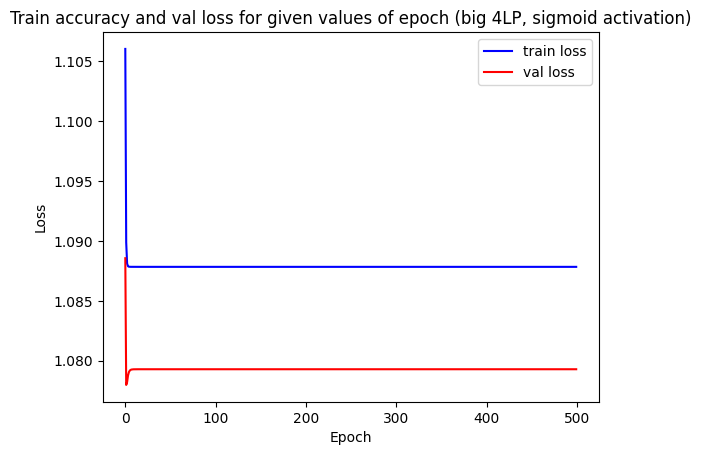

In [15]:
hidden_layers = [16]
activations = [sigmoid] * len(hidden_layers) + [softmax]

perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
perceptron.train(X_train, y_train, X_test, y_test, learning_rate=.01, epochs=500)

plt.title(f"Train accuracy and val loss for given values of epoch (small 2LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()
plt.show()

hidden_layers = [32, 16, 16]
activations = [sigmoid] * len(hidden_layers) + [softmax]

perceptron = Perceptron(13, hidden_layers, 3, activations, loss_function=ccategorical_crossentropy)
perceptron.train(X_train, y_train, X_test, y_test, learning_rate=.01, epochs=500)

plt.title(f"Train accuracy and val loss for given values of epoch (big 4LP, sigmoid activation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(perceptron.history["train_loss"], label="train loss", color="blue")
plt.plot(perceptron.history["val_loss"], label="val loss", color="red")
plt.legend()
plt.show()

In case of layers amounts and hidden layers widths, overfitting phenomenon is observable while using too big networks. Smaller network performs significantly better than the bigger one and eventually reaches smaller losses.